In [1]:
import numpy as np
import pandas as pd
bit=pd.read_csv('BitcoinHeistData.csv')

/tmp/ipykernel_41/1577792158.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
bit.head()

,address,year,day,length,weight,count,looped,neighbors,income,label
0,111K8kZAEnJg245r2cM6y9zgJGHZtJPy6,2017,11,18,0.008333,1,0,2,100050000.0,princetonCerber
1,1123pJv8jzeFQaCV4w644pzQJzVWay2zcA,2016,132,44,0.000244,1,0,1,100000000.0,princetonLocky
2,112536im7hy6wtKbpH1qYDWtTyMRAcA2p7,2016,246,0,1.000000,1,0,2,200000000.0,princetonCerber
3,1126eDRw2wqSkWosjTCre8cjjQW8sSeWH7,2016,322,72,0.003906,1,0,2,71200000.0,princetonCerber
4,1129TSjKtx65E35GiUo4AYVeyo48twbrGX,2016,238,144,0.072848,456,0,1,200000000.0,princetonLocky


In [3]:
bit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2916697 entries, 0 to 2916696
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   address    object 
 1   year       int64  
 2   day        int64  
 3   length     int64  
 4   weight     float64
 5   count      int64  
 6   looped     int64  
 7   neighbors  int64  
 8   income     float64
 9   label      object 
dtypes: float64(2), int64(6), object(2)
memory usage: 222.5+ MB


In [4]:
bit.shape

(2916697, 10)

In [5]:
bit['label'].unique()

array(['princetonCerber', 'princetonLocky', 'montrealCryptoLocker',
       'montrealCryptXXX', 'paduaCryptoWall', 'montrealWannaCry',
       'montrealDMALockerv3', 'montrealCryptoTorLocker2015',
       'montrealSamSam', 'montrealFlyper', 'montrealNoobCrypt',
       'montrealDMALocker', 'montrealGlobe', 'montrealEDA2',
       'paduaKeRanger', 'montrealVenusLocker', 'montrealXTPLocker',
       'paduaJigsaw', 'montrealGlobev3', 'montrealJigSaw',
       'montrealXLockerv5.0', 'montrealXLocker', 'montrealRazy',
       'montrealCryptConsole', 'montrealGlobeImposter', 'montrealSam',
       'montrealComradeCircle', 'montrealAPT', 'white'], dtype=object)

In [6]:
bit.loc[bit['label'] != 'white', 'label'] = 'ransom'

In [7]:
bit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2916697 entries, 0 to 2916696
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   address    object 
 1   year       int64  
 2   day        int64  
 3   length     int64  
 4   weight     float64
 5   count      int64  
 6   looped     int64  
 7   neighbors  int64  
 8   income     float64
 9   label      object 
dtypes: float64(2), int64(6), object(2)
memory usage: 222.5+ MB


In [8]:
bit.head()

,address,year,day,length,weight,count,looped,neighbors,income,label
0,111K8kZAEnJg245r2cM6y9zgJGHZtJPy6,2017,11,18,0.008333,1,0,2,100050000.0,ransom
1,1123pJv8jzeFQaCV4w644pzQJzVWay2zcA,2016,132,44,0.000244,1,0,1,100000000.0,ransom
2,112536im7hy6wtKbpH1qYDWtTyMRAcA2p7,2016,246,0,1.000000,1,0,2,200000000.0,ransom
3,1126eDRw2wqSkWosjTCre8cjjQW8sSeWH7,2016,322,72,0.003906,1,0,2,71200000.0,ransom
4,1129TSjKtx65E35GiUo4AYVeyo48twbrGX,2016,238,144,0.072848,456,0,1,200000000.0,ransom


In [9]:
bit.drop('address', axis=1, inplace=True)

In [10]:
bit.info

<bound method DataFrame.info of          year  day  length     weight  count  looped  neighbors        income  \
0        2017   11      18   0.008333      1       0          2  1.000500e+08   
1        2016  132      44   0.000244      1       0          1  1.000000e+08   
2        2016  246       0   1.000000      1       0          2  2.000000e+08   
3        2016  322      72   0.003906      1       0          2  7.120000e+07   
4        2016  238     144   0.072848    456       0          1  2.000000e+08   
...       ...  ...     ...        ...    ...     ...        ...           ...   
2916692  2018  330       0   0.111111      1       0          1  1.255809e+09   
2916693  2018  330       0   1.000000      1       0          1  4.409699e+07   
2916694  2018  330       2  12.000000      6       6         35  2.398267e+09   
2916695  2018  330       0   0.500000      1       0          1  1.780427e+08   
2916696  2018  330     144   0.073972   6800       0          2  1.123500e+08

In [11]:
bit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2916697 entries, 0 to 2916696
Data columns (total 9 columns):
 #   Column     Dtype  
---  ------     -----  
 0   year       int64  
 1   day        int64  
 2   length     int64  
 3   weight     float64
 4   count      int64  
 5   looped     int64  
 6   neighbors  int64  
 7   income     float64
 8   label      object 
dtypes: float64(2), int64(6), object(1)
memory usage: 200.3+ MB


Text(0.5, 0, 'length')

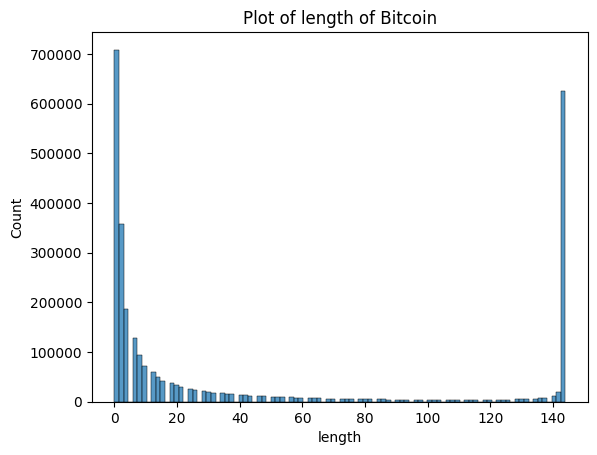

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(bit['length'], kde=False)
plt.title("Plot of length of Bitcoin")
plt.xlabel("length")

Text(0.5, 0, 'weight')

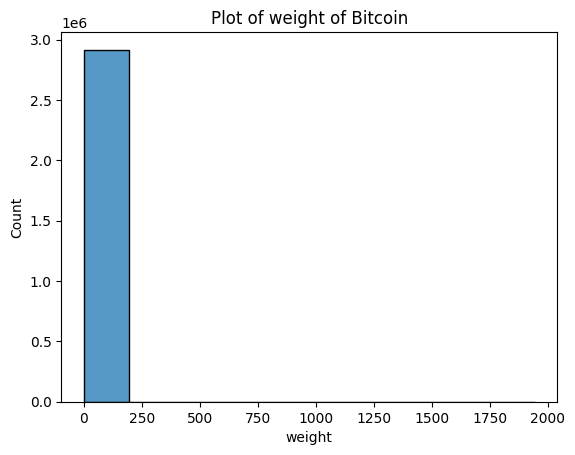

In [13]:
sns.histplot(bit['weight'],bins=10, kde=False)
plt.title("Plot of weight of Bitcoin")
plt.xlabel("weight")

In [14]:
bit = pd.get_dummies(bit, columns=["label"], drop_first=True)
bit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2916697 entries, 0 to 2916696
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   year         int64  
 1   day          int64  
 2   length       int64  
 3   weight       float64
 4   count        int64  
 5   looped       int64  
 6   neighbors    int64  
 7   income       float64
 8   label_white  bool   
dtypes: bool(1), float64(2), int64(6)
memory usage: 180.8 MB


In [15]:
from sklearn.model_selection import train_test_split

X = bit.drop('label_white', axis=1)
y = bit['label_white']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [16]:
X_train.shape

(2041687, 8)

In [17]:
X_test.shape

(875010, 8)

## Decision Trees

In [27]:
from sklearn.tree import DecisionTreeClassifier
model_dt = DecisionTreeClassifier(random_state=1).fit(X_train, y_train)
from sklearn.metrics import classification_report
print(f"Performance on TEST\n*******************\n{classification_report(y_test, model_dt.predict(X_test))}")
print(f"Performance on TRAIN\n********************\n{classification_report(y_train, model_dt.predict(X_train))}")


Performance on TEST
*******************
              precision    recall  f1-score   support

       False       0.40      0.43      0.41     12416
        True       0.99      0.99      0.99    862594

    accuracy                           0.98    875010
   macro avg       0.69      0.71      0.70    875010
weighted avg       0.98      0.98      0.98    875010

Performance on TRAIN
********************
              precision    recall  f1-score   support

       False       0.98      0.99      0.99     28997
        True       1.00      1.00      1.00   2012690

    accuracy                           1.00   2041687
   macro avg       0.99      1.00      0.99   2041687
weighted avg       1.00      1.00      1.00   2041687



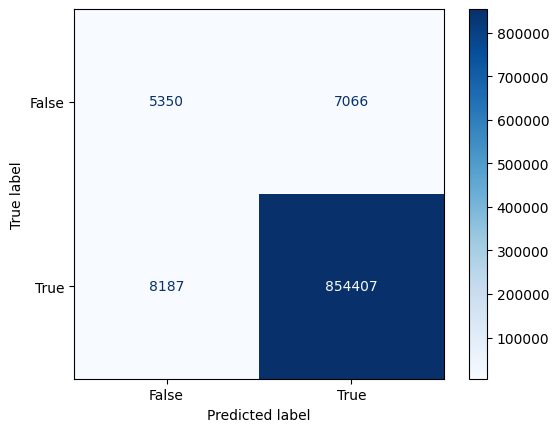

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay
cm_display = ConfusionMatrixDisplay.from_estimator(model_dt, X_test, y_test,cmap=plt.cm.Blues,normalize=None)

## Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# fit the LG model -- random_state is used to shuffle the data; max_iter is max # of iterations for solver to converge (default is 100)
model_lr = LogisticRegression(random_state=1, max_iter=1000).fit(X_train, y_train)
# print the report
print(f"Performance on TEST\n*******************\n{classification_report(y_test, model_lr.predict(X_test))}")
print(f"Performance on TRAIN\n********************\n{classification_report(y_train, model_lr.predict(X_train))}")

/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Performance on TEST
*******************
              precision    recall  f1-score   support

       False       0.00      0.00      0.00     12416
        True       0.99      1.00      0.99    862594

    accuracy                           0.99    875010
   macro avg       0.49      0.50      0.50    875010
weighted avg       0.97      0.99      0.98    875010



/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Performance on TRAIN
********************
              precision    recall  f1-score   support

       False       0.00      0.00      0.00     28997
        True       0.99      1.00      0.99   2012690

    accuracy                           0.99   2041687
   macro avg       0.49      0.50      0.50   2041687
weighted avg       0.97      0.99      0.98   2041687



/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


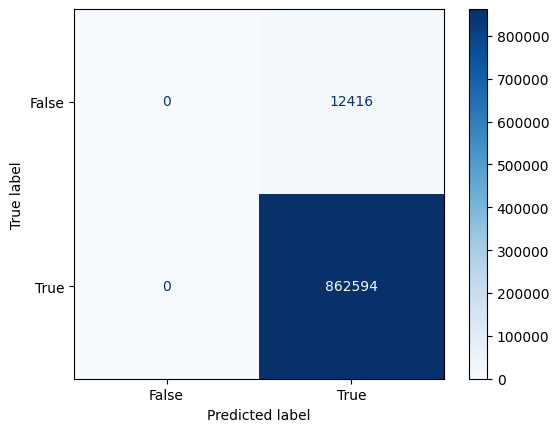

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay
cm_display = ConfusionMatrixDisplay.from_estimator(model_lr, X_test, y_test,cmap=plt.cm.Blues,normalize=None)

## KNN

In [22]:
from sklearn.neighbors import KNeighborsClassifier

# instantiate the model
knn = KNeighborsClassifier(n_neighbors=3)

# fit the model to the training set
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [23]:
# Check the accuracy on the test data
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

accuracy_test=accuracy_score(y_test, knn.predict(X_test))
print('Accuracy of knn on test data is : {:.2}'.format(accuracy_test))

# Check accuracy on the training data
accuracy_train=accuracy_score(y_train, knn.predict(X_train))
print('Accuracy of knn on train data is : {:.2}'.format(accuracy_train))

Accuracy of knn on test data is : 0.99
Accuracy of knn on train data is : 0.99


In [24]:
y_pred = knn.predict(X_test)
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"f1_score: {f1_score(y_test, y_pred)}")

Recall: 0.9972281281808127
Precision: 0.9891347343535115
f1_score: 0.993164943085451


## Random Forest (current issues)

In [29]:
"""from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

model = RandomForestClassifier()
param_grid = {
   "n_estimators": np.arange(start=10, stop=100, step=2),
   "max_depth": np.arange(start=2, stop=20),
   "min_samples_leaf": np.arange(start=1, stop=5),
   "class_weight": [{0: 0.1, 1: 0.9}, {0: 0.2, 1: 0.8}, {0: 0.3, 1: 0.7}],
}

gscv = GridSearchCV(model, param_grid, cv=5, n_jobs=8, scoring="recall", )
gscv.fit(X_train, y_train)
gscv.best_params_"""

'from sklearn.ensemble import RandomForestClassifier\nfrom sklearn.model_selection import GridSearchCV\n\nmodel = RandomForestClassifier()\nparam_grid = {\n   "n_estimators": np.arange(start=10, stop=100, step=2),\n   "max_depth": np.arange(start=2, stop=20),\n   "min_samples_leaf": np.arange(start=1, stop=5),\n   "class_weight": [{0: 0.1, 1: 0.9}, {0: 0.2, 1: 0.8}, {0: 0.3, 1: 0.7}],\n}\n\ngscv = GridSearchCV(model, param_grid, cv=5, n_jobs=8, scoring="recall", )\ngscv.fit(X_train, y_train)\ngscv.best_params_'

In [30]:
#from sklearn.metrics import classification_report
#print(f"Performance on TEST\n*******************\n{classification_report(y_test, model.predict(X_test))}")
#print(f"Performance on TRAIN\n********************\n{classification_report(y_train, model.predict(X_train))}")


## Naive Bayes

In [32]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       False       0.00      0.00      0.00     12416
        True       0.99      1.00      0.99    862594

    accuracy                           0.99    875010
   macro avg       0.49      0.50      0.50    875010
weighted avg       0.97      0.99      0.98    875010



/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
